In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow-addons
!pip install pyyaml h5py
!pip install toolz scikit-allel
!pip install -q -U keras-tuner


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 KB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Tensorflow version 2.9.2


## Setup

In [ ]:
import os
# os.environ["MODIN_CPUS"] = "8"
# from distributed import Client
# client = Client()
import numpy as np
import math
import re
import itertools
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
import keras_tuner as kt
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_addons as tfa
from sklearn import metrics
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import constraints
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras.applications import efficientnet as efn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from tensorflow.keras.constraints import Constraint
# import allel
from scipy.spatial.distance import squareform
%matplotlib inline   
from toolz import interleave
from tqdm import tqdm
import allel
from scipy.spatial.distance import squareform
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.model_selection import KFold,StratifiedKFold

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.9.2


## Hardware Config

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    TPU = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', TPU.master())
except ValueError:
    print('Running on GPU')
    TPU = None

if TPU:
    tf.config.experimental_connect_to_cluster(TPU)
    tf.tpu.experimental.initialize_tpu_system(TPU)
    strategy = tf.distribute.experimental.TPUStrategy(TPU)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

N_REPLICAS = strategy.num_replicas_in_sync
# Number of computing cores, is 8 for a TPU V3-8
print(f'N_REPLICAS: {N_REPLICAS}')

Running on TPU  grpc://10.0.169.74:8470


N_REPLICAS: 8


## Prepare the data

In [ ]:
root_dir = '[path]/'
new_data_header = ""
# get header
with open(root_dir + "DELL.chr22.genotypes.for.modeling.vcf", 'r') as f_in:
    # skip info
    for line_num in range(70):
        f_in.readline()

    new_data_header = f_in.readline()
# load data

# load genotype
genotypes = pd.read_csv(root_dir + "DELL.chr22.genotypes.for.modeling.vcf", comment='#', sep='\t', names=new_data_header.strip().split('\t'), header=1, index_col='Sample_id', dtype={'Sample_id':str})
headers = genotypes.columns[:]
genotypes

,1,2,3,4,7,8,10,13,15,16,...,835,836,837,838,839,840,842,843,846,847
Sample_id,,,,,,,,,,,,,,,,,,,,,
HG00097,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,...,0|0,0|1,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
HG00099,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
HG00100,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
HG00101,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
HG00102,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NA21137,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
NA21141,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,...,0|0,1|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
NA21142,0|0,0|0,0|0,0|0,0|0,0|0,0|1,0|0,0|0,0|0,...,0|0,1|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0


In [ ]:
ped_file = '[path]/integrated_call_samples.20130502.ALL.ped'
pedigree = pd.read_csv(ped_file, sep='\t', index_col='Individual ID')

In [ ]:
pedigree.head()

,Family ID,Paternal ID,Maternal ID,Gender,Phenotype,Population,Relationship,Siblings,Second Order,Third Order,Children,Other Comments
Individual ID,,,,,,,,,,,,
HG00096,HG00096,0,0,1,0,GBR,unrel,0,0,0,0,0
HG00097,HG00097,0,0,2,0,GBR,unrel,0,0,0,0,0
HG00098,HG00098,0,0,1,0,GBR,unrel,0,0,0,0,0
HG00099,HG00099,0,0,2,0,GBR,unrel,0,0,0,0,0
HG00100,HG00100,0,0,2,0,GBR,unrel,0,0,0,0,0


In [ ]:
Y_train = pedigree.loc[genotypes.index]['Population']
Y_train.shape

(2503,)

In [ ]:
X = genotypes[genotypes.index.isin(Y_train.index)]
X.shape

(2503, 573)

In [ ]:
X = X.replace({
    '0|0': 0,
    '0|1': 1,
    '1|0': 2,
    '1|1': 3
})
X.shape

(2503, 573)

### LD


In [ ]:
r = allel.rogers_huff_r(X.T)
LD = squareform(r ** 2)
LD.shape

(573, 573)

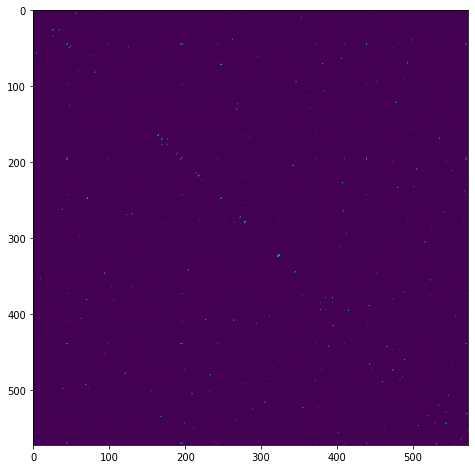

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(LD)

(array([420.,  46.,  29.,  31.,  47.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 <a list of 5 Patch objects>)

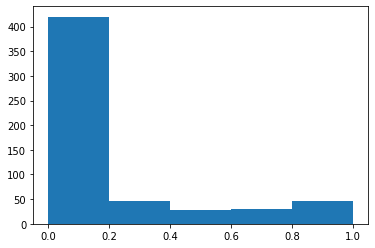

In [ ]:
bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
plt.hist(np.amax(LD, axis=1), bins=bins)

In [ ]:
LD_max_freqs = np.amax(LD, axis=1)
bin_labels = np.digitize(LD_max_freqs, bins=bins, right=True)
bin_general_labels, bin_counts = np.unique(bin_labels, return_counts=True)
bin_general_labels, bin_counts

(array([1, 2, 3, 4, 5]), array([420,  46,  29,  31,  47]))

In [ ]:
# hyperparameters
feature_size = X.shape[1]
inChannel = 3
learning_rate = 0.01
weight_decay = 0.00001
embed_dim = 64  # Embedding size for each token
num_heads = 8 # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
regularization_coef_l1 = 1e-4
dropout_rate = 0.25
attention_range = 0
chunk_size = X.shape[1]

## Convert to tensorflow dataset

In [ ]:
@tf.function()
def add_attention_mask(X_sample, y_sample):
  depth = 3
  mask_size = tf.cast(X_sample.shape[0]*0.5, dtype=tf.int64)
  mask_idx = tf.reshape(tf.random.shuffle(tf.range(X_sample.shape[0]))[:mask_size], (-1, 1))
  updates = tf.math.add(tf.ones(shape=(mask_idx.shape[0]), dtype=tf.int64), 1)
  X_masked = tf.tensor_scatter_nd_update(X_sample, mask_idx, updates)

  return tf.one_hot(X_masked, depth), tf.one_hot(y_sample, depth-1)

In [ ]:
def map_values_1(x):
  return 0 if (x == 0 or x == 1) else 1

def map_values_2(x):
  return 0 if (x == 0 or x == 2) else 1

def get_dataset(x, chunk_start, chunk_end, start_offset, end_offset, batch_size, training=True):
  AUTO = tf.data.AUTOTUNE

  _x = np.empty((x.shape[0] * 2, chunk_end-chunk_start), dtype=x.dtype)

  map_values_1_vec = np.vectorize(map_values_1)
  map_values_2_vec = np.vectorize(map_values_2)

  _x[0::2] = map_values_1_vec(x[:, chunk_start:chunk_end])
  _x[1::2] = map_values_2_vec(x[:, chunk_start:chunk_end])
  new_chunk_end = _x.shape[1]

  dataset = tf.data.Dataset.from_tensor_slices((_x,
                                                _x[:, start_offset:new_chunk_end-end_offset]))
  
  if training:
    dataset = dataset.shuffle(_x.shape[0], reshuffle_each_iteration=True)
    dataset = dataset.repeat()
  
  # Add Attention Mask
  dataset = dataset.map(add_attention_mask, num_parallel_calls=AUTO, deterministic=False)

  # Prefetech to not map the whole dataset
  dataset = dataset.prefetch(AUTO)

  dataset = dataset.batch(batch_size, drop_remainder=True, num_parallel_calls=AUTO)


  return dataset

## Custom Layers

In [ ]:
class CrossAttentionLayer(layers.Layer):
  def __init__(self, local_dim, global_dim,
               start_offset=0, end_offset=0,
               activation=tf.nn.gelu, dropout_rate=0.1,
               n_heads=num_heads):
    super(CrossAttentionLayer, self).__init__()
    self.local_dim = local_dim
    self.global_dim = global_dim
    self.dropout_rate = dropout_rate
    self.activation = activation
    self.start_offset = start_offset
    self.end_offset = end_offset
    self.num_heads = n_heads
    self.layer_norm00 = layers.LayerNormalization()
    self.layer_norm01 = layers.LayerNormalization()
    self.layer_norm1 = layers.LayerNormalization()
    self.ffn = tf.keras.Sequential(
          [
            layers.Dense(self.local_dim//2, activation=self.activation, 
                        ),
            layers.Dense(self.local_dim, 
                        activation=self.activation,
                        ), ]
      )
    self.add0 = layers.Add()
    self.add1 = layers.Add()
    self.attention = layers.MultiHeadAttention(num_heads=self.num_heads,
                                               key_dim=self.local_dim,)

  def call(self, inputs, training):
    local_repr = self.layer_norm00(inputs[0])
    global_repr = self.layer_norm01(inputs[1])
    query = local_repr[:, self.start_offset:local_repr.shape[1]-self.end_offset, :]
    key = global_repr
    value = global_repr

    # Generate cross-attention outputs: [batch_size, latent_dim, projection_dim].
    attention_output = self.attention(
        query, key, value
    )
    # Skip connection 1.
    attention_output = self.add0([attention_output, query])

    # Apply layer norm.
    attention_output = self.layer_norm1(attention_output)
    # Apply Feedforward network.
    outputs = self.ffn(attention_output)
    # Skip connection 2.
    outputs = self.add1([outputs, attention_output])
    return outputs

class MaskedTransformerBlock(layers.Layer):
  def __init__(self, embed_dim, num_heads, ff_dim, attention_range, start_offset=0, end_offset=0, attn_block_repeats=1, activation=tf.nn.gelu, dropout_rate=0.1, use_ffn=True):
    super(MaskedTransformerBlock, self).__init__()
    self.embed_dim = embed_dim
    self.num_heads = num_heads
    self.ff_dim = ff_dim
    self.start_offset = start_offset
    self.end_offset = end_offset
    self.attention_range = attention_range
    self.attn_block_repeats = attn_block_repeats
    self.activation = activation
    self.dropout_rate = dropout_rate
    self.use_ffn = use_ffn
    self.att0 = [layers.MultiHeadAttention(num_heads=self.num_heads, key_dim=self.embed_dim) for _ in range(attn_block_repeats)]
    if self.use_ffn:
      self.ffn = [tf.keras.Sequential(
          [
            layers.Dense(self.ff_dim, activation=self.activation, 
                        ),
            layers.Dense(self.embed_dim, 
                        activation=self.activation,
                        ), ]
      ) for _ in range(attn_block_repeats)]
    self.layer_norm0 = [layers.LayerNormalization() for _ in range(attn_block_repeats)]
    self.layer_norm1 = [layers.LayerNormalization() for _ in range(attn_block_repeats)]

  def build(self, input_shape):
    assert(self.end_offset >= 0)
    self.feature_size = input_shape[1]
    attention_mask = np.zeros((self.feature_size,
                               self.feature_size), dtype=bool)
    for i in range(self.start_offset, self.feature_size - self.end_offset):
      attention_indices = np.arange(max(0, i-self.attention_range), min(self.feature_size, i+self.attention_range))
      attention_mask[i, attention_indices] = True
    self.attention_mask = tf.constant(attention_mask[self.start_offset:self.feature_size-self.end_offset])

  def call(self, inputs, training):
    
    x = inputs
    for i in range(self.attn_block_repeats-1):
      x = self.layer_norm0[i](x)
      attn_output = self.att0[i](x, x)
      out1 = x + attn_output
      out1 = self.layer_norm1[i](out1)
      if self.use_ffn:
        ffn_output = self.ffn[i](out1)
        x = out1 + ffn_output
      else:
        x = out1

    x = self.layer_norm0[-1](inputs)
    attn_output = self.att0[-1](x[:, self.start_offset:x.shape[1]-self.end_offset, :], x,
                            )
    out1 = x[:, self.start_offset:x.shape[1]-self.end_offset, :] + attn_output
    out1 = self.layer_norm1[-1](out1)
    if self.use_ffn:
      ffn_output = self.ffn[-1](out1)
      x = out1 + ffn_output
    else:
      x = out1
    return x

class GenoEmbeddings(layers.Layer):
  def __init__(self, embedding_dim, 
               embeddings_initializer='glorot_uniform',
               embeddings_regularizer=None,
               activity_regularizer=None,
               embeddings_constraint=None):
    super(GenoEmbeddings, self).__init__()
    self.embedding_dim = embedding_dim
    self.embeddings_initializer = initializers.get(embeddings_initializer)
    self.embeddings_regularizer = regularizers.get(embeddings_regularizer)
    self.activity_regularizer = regularizers.get(activity_regularizer)
    self.embeddings_constraint = constraints.get(embeddings_constraint)

  def build(self, input_shape):
    # print(input_shape)
    
    self.num_of_allels = input_shape[-1]
    self.n_snps = input_shape[-2]
    self.position_embedding = layers.Embedding(
            input_dim=self.n_snps, output_dim=self.embedding_dim
        )
    self.embedding = self.add_weight(
            shape=(self.num_of_allels, self.embedding_dim),
            initializer=self.embeddings_initializer,
            trainable=True, name='geno_embeddings',
            regularizer=self.embeddings_regularizer,
            constraint=self.embeddings_constraint,
            experimental_autocast=False
        )
    self.positions = tf.range(start=0, limit=self.n_snps, delta=1)
  def call(self, inputs):
    self.immediate_result = tf.einsum('ijk,kl->ijl', inputs, self.embedding)
    return self.immediate_result + self.position_embedding(self.positions)


class Chunker(layers.Layer):
  def __init__(self, embed_dim, num_heads, ff_dim, chk_size=chunk_size,
               activation=tf.nn.gelu, dropout_rate=0.25, attn_block_repeats=1,
               attention_range=attention_range, include_embedding_layer=False):
    super(Chunker, self).__init__()
    self.concat = layers.Concatenate(axis=-2)
    self.chunk_size = chk_size
    self.embed_dim = embed_dim
    self.num_heads = num_heads
    self.ff_dim = ff_dim
    self.activation = activation
    self.dropout_rate = dropout_rate
    self.attention_range = attention_range
    self.attn_block_repeats = attn_block_repeats
    self.include_embedding_layer = include_embedding_layer
    
  def build(self, input_shape):
    self.chunk_starts = list(range(0, input_shape[1], self.chunk_size))
    self.chunk_ends = []
    for cs in self.chunk_starts:
      self.chunk_ends.append(min(cs+self.chunk_size, input_shape[1]))
    self.mask_starts = [max(0, cs-self.attention_range) for cs in self.chunk_starts]
    self.mask_ends = [min(ce+self.attention_range, input_shape[1]) for ce in self.chunk_ends]
    self.chunkers = [SelfAttnChunk(self.embed_dim, self.num_heads, self.ff_dim,
                           attention_range,
                           include_embedding_layer=self.include_embedding_layer,
                           start_offset=cs - self.mask_starts[i], 
                            end_offset=self.mask_ends[i]-self.chunk_ends[i],
                           attn_block_repeats=self.attn_block_repeats) for i, cs in enumerate(self.chunk_starts)]

  def call(self, inputs, training):
    x = inputs
    chunks = [chunker(x[:, self.mask_starts[i]:self.mask_ends[i]]) for i, chunker in enumerate(self.chunkers)]
    y = self.concat(chunks)
    return y


class SelfAttnChunk(layers.Layer):
  def __init__(self, embed_dim, num_heads, ff_dim, attention_range,
               start_offset=0, end_offset=0,
               attn_block_repeats=1,
               include_embedding_layer=False):
    super(SelfAttnChunk, self).__init__()
    self.attention_range = attention_range
    self.ff_dim = ff_dim
    self.num_heads = num_heads
    self.embed_dim = embed_dim
    self.attn_block_repeats = attn_block_repeats
    self.include_embedding_layer = include_embedding_layer

    self.attention_block = MaskedTransformerBlock(self.embed_dim,
                                                   self.num_heads, self.ff_dim,
                                                   attention_range, start_offset,
                                                   end_offset, attn_block_repeats=1)
    if include_embedding_layer:
      self.embedding = GenoEmbeddings(embed_dim)
    

  def build(self, input_shape):
    pass
  
  def call(self, inputs, training):
    if self.include_embedding_layer:
      x = self.embedding(inputs)
    else:
      x = inputs
    x = self.attention_block(x)
    return x

class CrossAttnChunk(layers.Layer):
  def __init__(self, start_offset=0, end_offset=0, n_heads = num_heads):
    super(CrossAttnChunk, self).__init__()
    self.attention_range = attention_range
    self.start_offset = start_offset
    self.end_offset = end_offset
    self.n_heads = n_heads
    

  def build(self, input_shape):
    self.local_dim = input_shape[0][-1]
    self.global_dim = input_shape[1][-1]
    self.attention_block = CrossAttentionLayer(self.local_dim, self.global_dim,
                                              self.start_offset, self.end_offset,
                                              n_heads=self.n_heads)
    pass
  
  def call(self, inputs, training):
    x = inputs
    x = self.attention_block(x)
    return x


## Modules

In [ ]:
class ConvBlock(layers.Layer):
  def __init__(self, embed_dim):
    super(ConvBlock, self).__init__()
    self.embed_dim = embed_dim
    self.const = None
    self.conv000 = layers.Conv1D(embed_dim, 3, padding='same', activation=tf.nn.gelu,
                                 kernel_constraint=self.const,
                                 kernel_initializer=tf.keras.initializers.variance_scaling,
                    )
    self.conv010 = layers.Conv1D(embed_dim, 5, padding='same', activation=tf.nn.gelu,
                                 kernel_constraint=self.const,
                                 kernel_initializer=tf.keras.initializers.variance_scaling,
                    )
    self.conv011 = layers.Conv1D(embed_dim, 7, padding='same', activation=tf.nn.gelu,
                                 kernel_constraint=self.const,
                                 kernel_initializer=tf.keras.initializers.variance_scaling,
                    )
    
    self.conv020 = layers.Conv1D(embed_dim, 7, padding='same', activation=tf.nn.gelu,
                                 kernel_constraint=self.const,
                                 kernel_initializer=tf.keras.initializers.variance_scaling,
                    )
    self.conv021 = layers.Conv1D(embed_dim, 15, padding='same', activation=tf.nn.gelu,
                                 kernel_constraint=self.const,
                                 kernel_initializer=tf.keras.initializers.variance_scaling,
                    )
    self.add = layers.Add()
    
    self.conv100 = layers.Conv1D(embed_dim, 3, padding='same',
                                 activation=tf.nn.gelu,
                                 kernel_constraint=self.const,
                                 kernel_initializer=tf.keras.initializers.variance_scaling,)
    self.bn0 = layers.BatchNormalization()
    self.bn1 = layers.BatchNormalization()
    self.dw_conv = layers.DepthwiseConv1D(embed_dim, 1, padding='same',
                                 kernel_initializer=tf.keras.initializers.variance_scaling,)
    self.activation = layers.Activation(tf.nn.gelu)


  def call(self, inputs, training):
    xa = self.conv000(inputs)
    
    xb = self.conv010(xa)
    xb = self.conv011(xb)

    xc = self.conv020(xa)
    xc = self.conv021(xc)

    xa = self.add([xb, xc])
    xa = self.conv100(xa)
    xa = self.bn0(xa)
    xa = self.dw_conv(xa)
    xa = self.bn1(xa)
    xa = self.activation(xa)
    return xa

def chunk_module(embed_dim, num_heads, input_len, input_channels, attention_range,
               start_offset=0, end_offset=0,
               attn_block_repeats=1, include_embedding=False):
  projection_dim = embed_dim
  inputs = layers.Input(shape=(input_len, embed_dim))
  xa = inputs
  xa0 = SelfAttnChunk(projection_dim, num_heads, projection_dim//2, attention_range,
            start_offset, end_offset, 1, include_embedding_layer=False)(xa)
  
  xa = ConvBlock(projection_dim)(xa0)
  xa_skip = ConvBlock(projection_dim)(xa)

  xa = layers.Dense(projection_dim, activation=tf.nn.gelu)(xa)
  xa = ConvBlock(projection_dim)(xa)
  xa = CrossAttnChunk(0, 0)([xa, xa0])
  xa = layers.Dropout(0.25)(xa)
  xa = ConvBlock(projection_dim)(xa)

  xa = layers.Concatenate(axis=-1)([xa_skip, xa])
  
  xa = layers.Conv1D(projection_dim//2, 5, padding='same', activation=tf.nn.gelu,
                                 kernel_initializer=tf.keras.initializers.variance_scaling,)(xa)
  
  xa_out1 = layers.Conv1D(inChannel - 1, 5, padding='same',
                          kernel_initializer=tf.keras.initializers.glorot_normal,
                          activation=tf.nn.softmax)(xa)
  
  model = keras.Model(inputs=inputs, outputs=xa_out1)
  return model

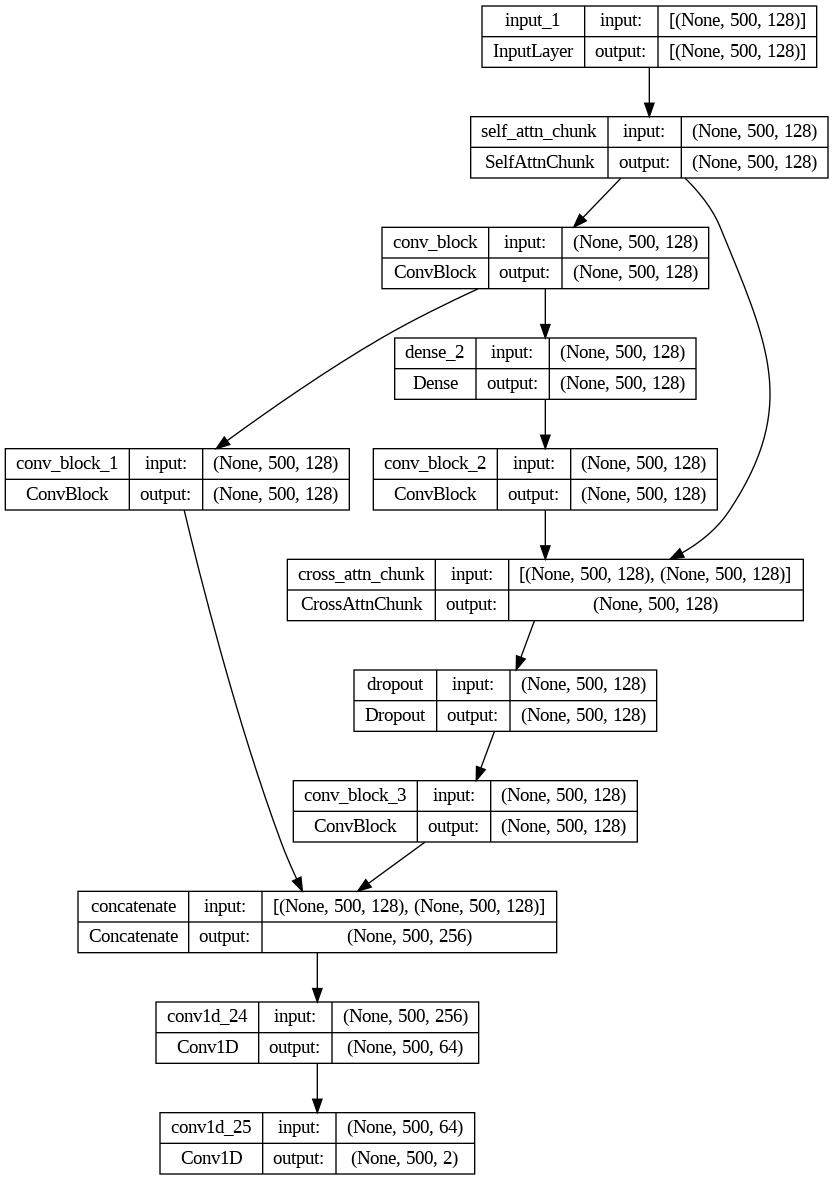

In [ ]:
temp_model = chunk_module(128, 1,500, 3,300,)
temp_model.build((2, 500, 3))

tf.keras.utils.plot_model(temp_model, show_shapes=True,
                                        expand_nested=True)

In [ ]:
num_classes = len(np.unique(Y_train))
num_classes

26

## Model

In [ ]:
[path]

In [ ]:
class MyCustomLoss(tf.keras.losses.Loss):

  def call(self, y_true, y_pred):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    
    loss_obj = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.SUM)
    cat_loss = loss_obj(y_true, y_pred)

    loss_obj = tf.keras.losses.KLDivergence(reduction=tf.keras.losses.Reduction.SUM)
    kl_loss = loss_obj(y_true, y_pred)

    return cat_loss + kl_loss

In [ ]:
METRIC = "val_loss"

def create_callbacks(kfold=0, metric = METRIC):

    reducelr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor= metric,
        mode='auto',
        factor=0.2,
        patience=3,
        verbose=0
    )

    earlystop = tf.keras.callbacks.EarlyStopping(
        monitor= metric,
        mode='auto',
        patience= 20, 
        verbose=1,
        restore_best_weights=True
    )
    
    callbacks = [
                 reducelr,
                 earlystop]         
    
    return callbacks

In [ ]:
def create_model():
  model =  SplitTransformer(embed_dim=128,
      num_heads=40,
      attn_block_repeats=1,
      chunk_size=X.shape[1],
      activation="gelu",
      attention_range=0)
  optimizer = tfa.optimizers.LAMB(learning_rate=learning_rate)
  model.compile(optimizer, loss=MyCustomLoss(), metrics=tf.keras.metrics.CategoricalAccuracy())
  return model


In [ ]:
temp_model = create_model()
temp_model.build((1, X.shape[1], inChannel))
temp_model.summary()

Model: "split_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 573, 2)            5992642   
                                                                 
 concatenate_2 (Concatenate)  multiple                 0         
                                                                 
 conv1d_52 (Conv1D)          multiple                  24704     
                                                                 
Total params: 6,017,346
Trainable params: 6,015,298
Non-trainable params: 2,048
_________________________________________________________________


In [ ]:
def get_three_sets(x, y, random_state, population_label, missing_perc):
  np.random.seed(seed=random_state)
  _x = x[x.index.isin(y.index)].to_numpy()
  _y = y.to_numpy()
  x_train, x_test, y_train, y_test = train_test_split(_x, _y, test_size=0.20,
                                        random_state=random_state,
                                        shuffle=True,
                                        stratify=_y,)
  train_indices, test_indices = train_test_split(y.index, test_size=0.20,
                                        random_state=random_state,
                                        shuffle=True,
                                        stratify=_y,)
  return x_train, y_train, (x_test, y_test), test_indices


In [ ]:
np.unique(Y_train.values)

array(['ACB', 'ASW', 'BEB', 'CDX', 'CEU', 'CHB', 'CHS', 'CLM', 'ESN',
       'FIN', 'GBR', 'GIH', 'GWD', 'IBS', 'ITU', 'JPT', 'KHV', 'LWK',
       'MSL', 'MXL', 'PEL', 'PJL', 'PUR', 'STU', 'TSI', 'YRI'],
      dtype=object)

## Training

In [ ]:
# A TPU V3-8 has 8 computing cores, the global batch size will be 1/16 x 8 = 8/128
BATCH_SIZE_BASE = 2
# Training configuration
BATCH_SIZE = BATCH_SIZE_BASE * N_REPLICAS if TPU else 5
BATCH_SIZE

16

In [ ]:
# With constraint
missing_perc = 0.1
N_SPLITS=3
NUM_EPOCHS = 1000
accuracies = []
results = None
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=2022)
fold = 0
_x = X[X.index.isin(Y_train.index)].to_numpy()
_y = Y_train.to_numpy()
for train_index, test_index in kf.split(_x):
  fold += 1
    
  print(f"Training using fold {fold}")
  
  x_train, y_train, test_dataset, test_indices = _x[train_index], _y[train_index], (_x[test_index], _y[test_index]),Y_train.index[test_index]
  x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.10,
                                      random_state=fold,
                                      shuffle=True)
  
  steps_per_epoch = 2*x_train.shape[0]//BATCH_SIZE
  validation_steps = 2*x_valid.shape[0]//BATCH_SIZE
  train_dataset = get_dataset(x_train, 0, feature_size, 0, 0, BATCH_SIZE)
  valid_dataset = get_dataset(x_valid, 0, feature_size, 0, 0, BATCH_SIZE, training=False)

  K.clear_session()
  callbacks = create_callbacks()
  with strategy.scope():
    model = create_model()
    history = model.fit(train_dataset, steps_per_epoch=steps_per_epoch, epochs=NUM_EPOCHS, 
            validation_data=valid_dataset,
            validation_steps=validation_steps,
            callbacks=callbacks, verbose=1)
  for missing_perc in [
                         0.05,
                         0.1,
                         0.2
                         ]:
    save_name = f"[path]/STI_WE/preds_mixed_mr_{missing_perc}_rs_{fold}_.csv"
    save_name_numpy = f"[path]/Chr.22.DELS/STI_WE/preds_mixed_mr_{missing_perc}_rs_{fold}"
    avg_accuracy = []
    preds = []
    true_labels = []
    
    to_save_array = np.zeros((test_dataset[0].shape[0], test_dataset[0].shape[1]), dtype=object)
    test_X_missing = np.empty((test_dataset[0].shape[0] * 2, test_dataset[0].shape[1]), dtype=test_dataset[0].dtype)
    map_values_1_vec = np.vectorize(map_values_1)
    map_values_2_vec = np.vectorize(map_values_2)
    test_X_missing[0::2] = map_values_1_vec(test_dataset[0])
    test_X_missing[1::2] = map_values_2_vec(test_dataset[0])
    test_X_missing = to_categorical(test_X_missing, 3)
    
    
    for i in tqdm(range(test_dataset[0].shape[0])):
      missing_index, _ = train_test_split(np.arange(x_train.shape[1]), train_size=missing_perc,
                                    random_state=i + fold,
                                    shuffle=True,
                                    stratify=bin_labels
                                    )
      test_X_missing[i*2:i*2+2, missing_index, :] = [0, 0, 1]
      # predict
    predict_onehots = model.predict(test_X_missing, verbose=0)
    np.save(save_name_numpy, predict_onehots, allow_pickle=False)
    for i in tqdm(range(test_dataset[0].shape[0])):  
      missing_index, _ = train_test_split(np.arange(x_train.shape[1]), train_size=missing_perc,
                                    random_state=i + fold,
                                    shuffle=True,
                                    stratify=bin_labels
                                    )
      predict_missing_onehot = predict_onehots[i*2:(i+1)*2, missing_index, :]
      # predict label
      predict_missing = np.argmax(predict_missing_onehot, axis=2)
      predict_missing_final = np.zeros((1, predict_missing.shape[1]))
      for j in range(predict_missing.shape[1]):
        if predict_missing[:, j].tolist() == [0, 0]:
          predict_missing_final[:, j] = 0
        elif predict_missing[:, j].tolist() == [0, 1]:
          predict_missing_final[:, j] = 1
        elif predict_missing[:, j].tolist() == [1, 0]:
          predict_missing_final[:, j] = 2
        elif predict_missing[:, j].tolist() == [1, 1]:
          predict_missing_final[:, j] = 3
        else:
          predict_missing_final[:, j] = 4
      preds.extend(predict_missing_final.ravel().tolist())
      
      predict_haplotypes = np.argmax(predict_onehots[i*2:(i+1)*2], axis=2)
      for j in range(predict_onehots.shape[1]):
        if predict_haplotypes[:, j].tolist() == [0,0]:
          to_save_array[i, j] = '0|0'
        elif predict_haplotypes[:, j].tolist() == [0,1]:
          to_save_array[i, j] = '0|1'
        elif predict_haplotypes[:, j].tolist() == [1,0]:
          to_save_array[i, j] = '1|0'
        elif predict_haplotypes[:, j].tolist() == [1, 1]:
          to_save_array[i, j] = '1|1'
        else:
          to_save_array[i, j] = '.|.'
      # real label
      label_missing_onehot = test_dataset[0][i:i + 1, missing_index]
      label_missing = test_dataset[0][i:i + 1, missing_index]
      true_labels.extend(label_missing.ravel().tolist())
      # accuracy
      correct_prediction = np.equal(predict_missing_final, label_missing)
      accuracy = np.mean(correct_prediction)

      avg_accuracy.append(accuracy)

    df = pd.DataFrame(to_save_array, columns= headers[:], index = Y_train.index[test_index])
    df.to_csv(save_name)
    print('The average imputation accuracy' \
          'on test data with {} missing genotypes is {:.4f}: '
        .format(missing_perc, np.mean(avg_accuracy)))
    cnf_matrix = confusion_matrix(true_labels, preds)
    FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)
    FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
    TP = np.diag(cnf_matrix)
    TN = cnf_matrix.sum() - (FP + FN + TP)
    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP)
    print(f"Sensitivity: {np.mean(TPR)}")
    print(f"Specificity: {np.mean(TNR)}")
    print(f"F1-score macro: {f1_score(true_labels, preds, average='macro')}")
    print(f"F1-score micro: {f1_score(true_labels, preds, average='micro')}")
    accuracies.append(np.mean(avg_accuracy))
  print(f"=====================================")
        
    

Training using fold 1
Epoch 1/1000
187/187 [==============================] - 118s 144ms/step - loss: 149.0931 - categorical_accuracy: 0.9810 - val_loss: 370.1388 - val_categorical_accuracy: 0.9751 - lr: 0.0100
Epoch 2/1000
187/187 [==============================] - 9s 46ms/step - loss: 97.4422 - categorical_accuracy: 0.9875 - val_loss: 237.1241 - val_categorical_accuracy: 0.9736 - lr: 0.0100
Epoch 3/1000
187/187 [==============================] - 8s 44ms/step - loss: 92.3187 - categorical_accuracy: 0.9878 - val_loss: 1186.5533 - val_categorical_accuracy: 0.9365 - lr: 0.0100
Epoch 4/1000
187/187 [==============================] - 8s 44ms/step - loss: 93.1292 - categorical_accuracy: 0.9878 - val_loss: 732.9636 - val_categorical_accuracy: 0.9751 - lr: 0.0100
Epoch 5/1000
187/187 [==============================] - 8s 45ms/step - loss: 88.3560 - categorical_accuracy: 0.9880 - val_loss: 294.3478 - val_categorical_accuracy: 0.9752 - lr: 0.0100
Epoch 6/1000
187/187 [==========================

100%|██████████| 835/835 [00:01<00:00, 571.07it/s]


The average imputation accuracyon test data with 0.05 missing genotypes is 0.9643: 
Sensitivity: 0.42226310531954875
Specificity: 0.8242815992494242
F1-score macro: 0.4588972267860424
F1-score micro: 0.9643284858853721


100%|██████████| 835/835 [00:01<00:00, 510.92it/s]


The average imputation accuracyon test data with 0.1 missing genotypes is 0.9633: 
Sensitivity: 0.42484005665457303
Specificity: 0.8273742364022006
F1-score macro: 0.46147748066169325
F1-score micro: 0.9632734530938124


100%|██████████| 835/835 [00:01<00:00, 531.36it/s]


The average imputation accuracyon test data with 0.2 missing genotypes is 0.9626: 
Sensitivity: 0.4159345263692751
Specificity: 0.8189782738373954
F1-score macro: 0.4535625680235929
F1-score micro: 0.9625801029519907
Training using fold 2
Epoch 1/1000
187/187 [==============================] - 45s 62ms/step - loss: 157.6071 - categorical_accuracy: 0.9787 - val_loss: 420.8160 - val_categorical_accuracy: 0.9448 - lr: 0.0100
Epoch 2/1000
187/187 [==============================] - 9s 49ms/step - loss: 97.8383 - categorical_accuracy: 0.9877 - val_loss: 500.0647 - val_categorical_accuracy: 0.9823 - lr: 0.0100
Epoch 3/1000
187/187 [==============================] - 9s 48ms/step - loss: 91.7533 - categorical_accuracy: 0.9879 - val_loss: 227.5152 - val_categorical_accuracy: 0.9855 - lr: 0.0100
Epoch 4/1000
187/187 [==============================] - 9s 46ms/step - loss: 87.5512 - categorical_accuracy: 0.9880 - val_loss: 2458.1208 - val_categorical_accuracy: 0.8876 - lr: 0.0100
Epoch 5/1000
187/1

100%|██████████| 834/834 [00:01<00:00, 597.98it/s]


The average imputation accuracyon test data with 0.05 missing genotypes is 0.9619: 
Sensitivity: 0.4177606253869603
Specificity: 0.826486019713127
F1-score macro: 0.4460366107135349
F1-score micro: 0.9618876327509421


100%|██████████| 834/834 [00:01<00:00, 567.44it/s]


The average imputation accuracyon test data with 0.1 missing genotypes is 0.9632: 
Sensitivity: 0.4233400388478831
Specificity: 0.8231976819376382
F1-score macro: 0.4558568381403949
F1-score micro: 0.9632083806638899


100%|██████████| 834/834 [00:01<00:00, 561.52it/s]


The average imputation accuracyon test data with 0.2 missing genotypes is 0.9629: 
Sensitivity: 0.4159648007011029
Specificity: 0.8167702459102966
F1-score macro: 0.4537281168933043
F1-score micro: 0.9629349152257142
Training using fold 3
Epoch 1/1000
187/187 [==============================] - 44s 60ms/step - loss: 139.3522 - categorical_accuracy: 0.9839 - val_loss: 233.9772 - val_categorical_accuracy: 0.9745 - lr: 0.0100
Epoch 2/1000
187/187 [==============================] - 8s 44ms/step - loss: 96.0546 - categorical_accuracy: 0.9879 - val_loss: 368.5645 - val_categorical_accuracy: 0.9854 - lr: 0.0100
Epoch 3/1000
187/187 [==============================] - 8s 44ms/step - loss: 90.4318 - categorical_accuracy: 0.9880 - val_loss: 572.0290 - val_categorical_accuracy: 0.9772 - lr: 0.0100
Epoch 4/1000
187/187 [==============================] - 8s 44ms/step - loss: 87.0999 - categorical_accuracy: 0.9881 - val_loss: 666.4899 - val_categorical_accuracy: 0.9802 - lr: 0.0100
Epoch 5/1000
187/18

100%|██████████| 834/834 [00:01<00:00, 572.25it/s]


The average imputation accuracyon test data with 0.05 missing genotypes is 0.9632: 
Sensitivity: 0.42111038745212626
Specificity: 0.8221228410274944
F1-score macro: 0.4489641667394151
F1-score micro: 0.9632151421719767


100%|██████████| 834/834 [00:01<00:00, 552.39it/s]


The average imputation accuracyon test data with 0.1 missing genotypes is 0.9628: 
Sensitivity: 0.42202323475081005
Specificity: 0.8229084099289201
F1-score macro: 0.45828905052309066
F1-score micro: 0.9627666288022214


100%|██████████| 834/834 [00:01<00:00, 486.99it/s]


The average imputation accuracyon test data with 0.2 missing genotypes is 0.9630: 
Sensitivity: 0.41253528805330925
Specificity: 0.818392918891436
F1-score macro: 0.4519744554276306
F1-score micro: 0.9630190584374606
